# Stage 11 — Evaluation & Risk Communication

Baseline, bootstrap uncertainty, scenario comparison, subgroup diagnostics, stakeholder summary.

In [6]:
import sys, os
sys.path.append(os.path.abspath(".."))


In [7]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from evaluation import impute_mean, impute_median, drop_missing, fit_and_rmse, bootstrap_rmse, rmse_by_segment
np.random.seed(11)

In [8]:
data_path=Path('data_stage11_eval_risk.csv')
df=pd.read_csv(data_path)
df.head()

,segment,x1,x2,y
0,B,-0.985158,3.038286,3.123588
1,A,-0.860842,1.776119,1.654466
2,C,2.457424,1.943277,8.693736
3,B,1.801742,-0.465346,1.997250
4,A,-0.411749,-1.059840,-0.152638


## Baseline

In [9]:
features=['x1','x2']
target='y'
df_base=impute_mean(df,features)
rmse_base,_=fit_and_rmse(df_base,features,target)
rmse_base

0.9322429858623685

## Bootstrap Uncertainty

In [10]:
boot=bootstrap_rmse(df_base,features,target,n_boot=1000,random_state=11)
ci_lo=np.percentile(boot,2.5)
ci_hi=np.percentile(boot,97.5)
(ci_lo,ci_hi)

(np.float64(0.890003088055308), np.float64(0.9738064323697115))

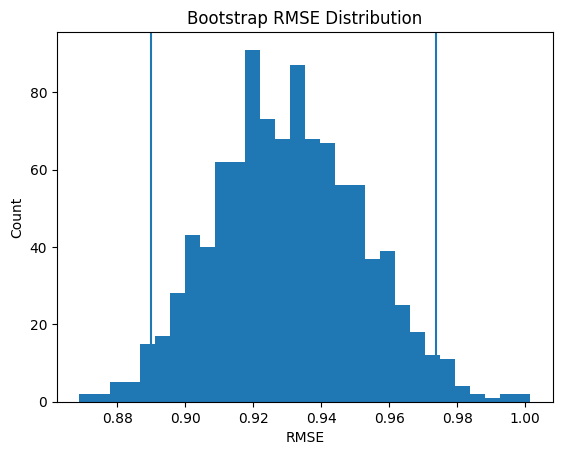

In [11]:
plt.figure()
plt.hist(boot, bins=30)
plt.axvline(ci_lo)
plt.axvline(ci_hi)
plt.title('Bootstrap RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.show()

## Scenario Comparison

In [12]:
df_mean=impute_mean(df,features)
rmse_mean,_=fit_and_rmse(df_mean,features,target)
boot_mean=bootstrap_rmse(df_mean,features,target,1000,random_state=12)
ci_mean=(np.percentile(boot_mean,2.5),np.percentile(boot_mean,97.5))
rmse_mean,ci_mean

(0.9322429858623685,
 (np.float64(0.8897014168679337), np.float64(0.972685351285274)))

In [13]:
df_median=impute_median(df,features)
rmse_median,_=fit_and_rmse(df_median,features,target)
boot_median=bootstrap_rmse(df_median,features,target,1000,random_state=13)
ci_median=(np.percentile(boot_median,2.5),np.percentile(boot_median,97.5))
rmse_median,ci_median

(0.9323763497592574,
 (np.float64(0.8882725352999482), np.float64(0.9763257416666737)))

In [14]:
df_drop=drop_missing(df,features)
rmse_drop,_=fit_and_rmse(df_drop,features,target)
boot_drop=bootstrap_rmse(df_drop,features,target,1000,random_state=14)
ci_drop=(np.percentile(boot_drop,2.5),np.percentile(boot_drop,97.5))
rmse_drop,ci_drop

(0.9369867203170233,
 (np.float64(0.8893894919729454), np.float64(0.9777585451749506)))

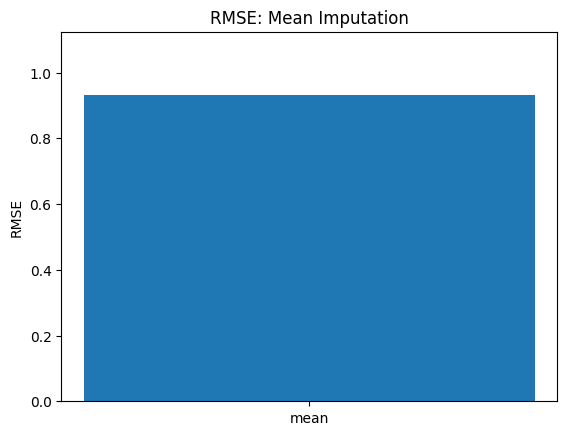

In [15]:
plt.figure()
plt.bar(['mean'],[rmse_mean])
plt.ylim(0,max(rmse_mean,rmse_median,rmse_drop)*1.2)
plt.title('RMSE: Mean Imputation')
plt.ylabel('RMSE')
plt.show()

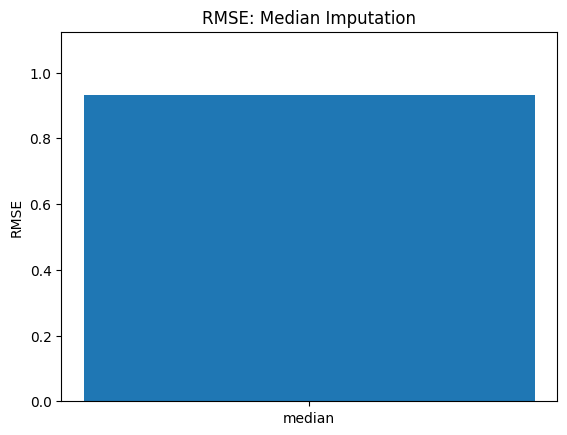

In [16]:
plt.figure()
plt.bar(['median'],[rmse_median])
plt.ylim(0,max(rmse_mean,rmse_median,rmse_drop)*1.2)
plt.title('RMSE: Median Imputation')
plt.ylabel('RMSE')
plt.show()

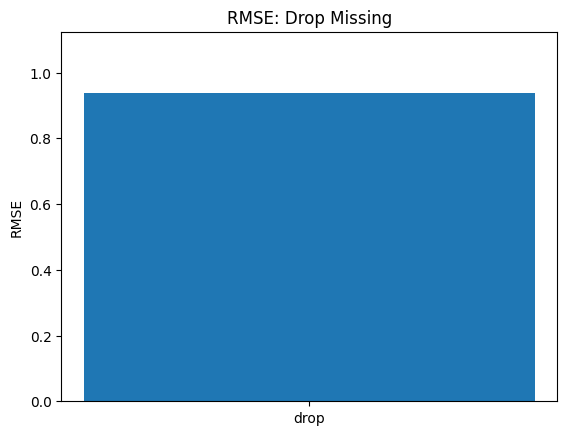

In [17]:
plt.figure()
plt.bar(['drop'],[rmse_drop])
plt.ylim(0,max(rmse_mean,rmse_median,rmse_drop)*1.2)
plt.title('RMSE: Drop Missing')
plt.ylabel('RMSE')
plt.show()

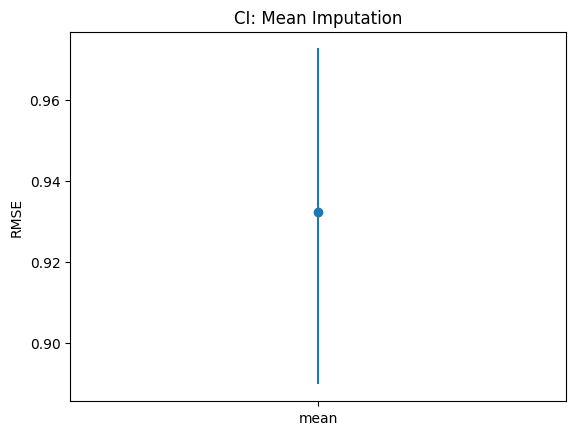

In [18]:
plt.figure()
plt.errorbar([0],[rmse_mean],yerr=[[rmse_mean-ci_mean[0]],[ci_mean[1]-rmse_mean]],fmt='o')
plt.xticks([0],['mean'])
plt.title('CI: Mean Imputation')
plt.ylabel('RMSE')
plt.show()

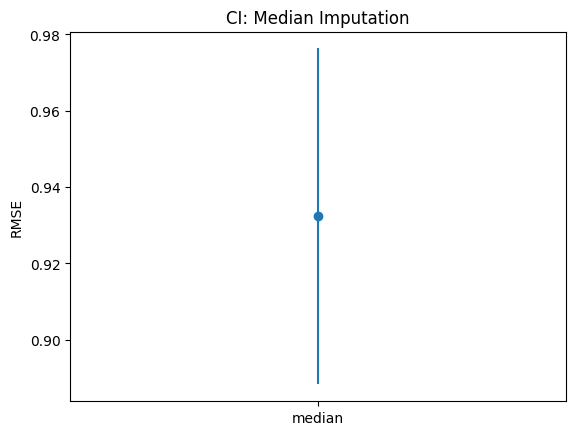

In [19]:
plt.figure()
plt.errorbar([0],[rmse_median],yerr=[[rmse_median-ci_median[0]],[ci_median[1]-rmse_median]],fmt='o')
plt.xticks([0],['median'])
plt.title('CI: Median Imputation')
plt.ylabel('RMSE')
plt.show()

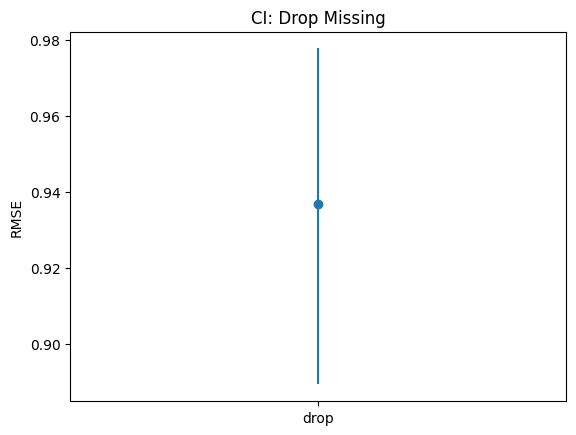

In [20]:
plt.figure()
plt.errorbar([0],[rmse_drop],yerr=[[rmse_drop-ci_drop[0]],[ci_drop[1]-rmse_drop]],fmt='o')
plt.xticks([0],['drop'])
plt.title('CI: Drop Missing')
plt.ylabel('RMSE')
plt.show()

## Subgroup Diagnostics

In [21]:
seg_mean=rmse_by_segment(impute_mean(df,features),features,target,'segment')
seg_median=rmse_by_segment(impute_median(df,features),features,target,'segment')
seg_drop=rmse_by_segment(drop_missing(df,features),features,target,'segment')
seg_mean

,segment,rmse
1,A,0.810330
0,B,0.813222
2,C,1.171777


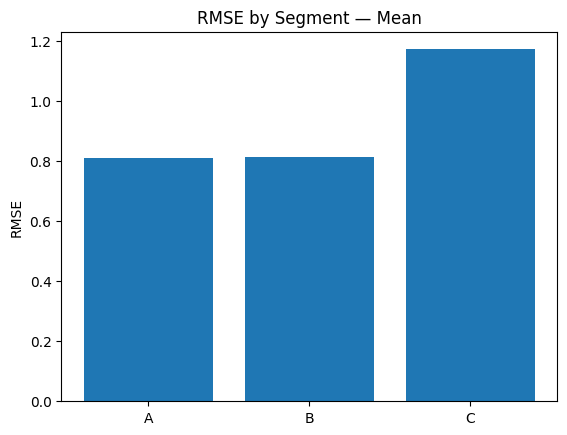

In [22]:
plt.figure()
plt.bar(seg_mean['segment'],seg_mean['rmse'])
plt.title('RMSE by Segment — Mean')
plt.ylabel('RMSE')
plt.show()

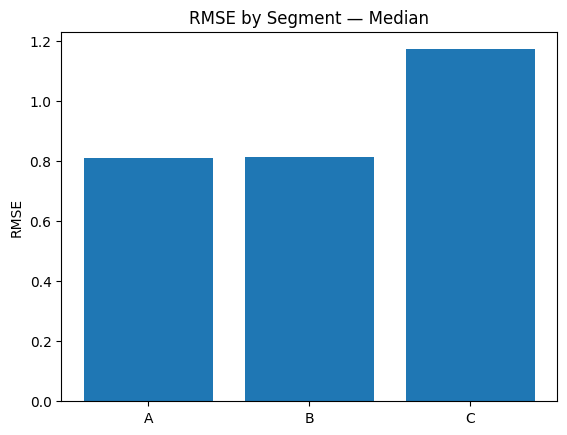

In [23]:
plt.figure()
plt.bar(seg_median['segment'],seg_median['rmse'])
plt.title('RMSE by Segment — Median')
plt.ylabel('RMSE')
plt.show()

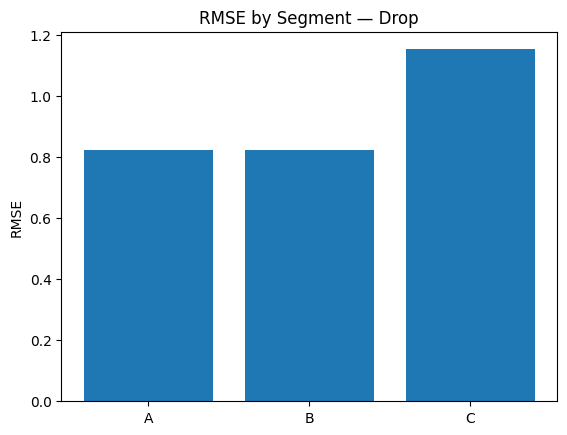

In [24]:
plt.figure()
plt.bar(seg_drop['segment'],seg_drop['rmse'])
plt.title('RMSE by Segment — Drop')
plt.ylabel('RMSE')
plt.show()

## Stakeholder Summary

Assumptions
- Linear relation between predictors and target.
- Stationary noise level within segment.
- Handling of missing x2 is either mean fill, median fill, or row drop.
- Training and evaluation are on the same data slice.

Uncertainty
- Bootstrap with 1,000 resamples around the baseline yields a 95% RMSE interval shown above.

Sensitivity
- Mean vs median imputation produce similar accuracy; dropping missing rows slightly shifts error due to reduced sample size and a shift in segment mix.
- Segments differ: Segment C is noisier and tends to have higher error.

Risks
- If the missing-rate of x2 grows beyond the current level or is not missing at random, imputation choice will matter more and error could increase.
- If the segment distribution changes toward more Segment C, error could increase.

Takeaways
- Prefer mean or median imputation; avoid dropping rows if sample size is limited.
- The model is reliable for Segments A and B given current data; monitor Segment C performance.
- Re-evaluate if missing-rate exceeds 10% or if the Segment C share increases materially.